# Caracterización de la curvatura del codo - derivadas y punto de inflexión.

## Inicialmente se importan todas las librerías necesarias para este estudio.

In [213]:
# Librerias basicas:
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [214]:
# Ajustar la configuración para mostrar todas las filas del dataframe
pd.set_option('display.max_rows', None)

# Ajustar la configuración para mostrar todas las columnas del dataframe
pd.set_option('display.max_columns', None)

# Realizamos la carga de datos que consideramos que tienen una rampa de corriente buena.

## 30 Segundos

### 14V30s

In [230]:
# Cargamos los dataframes en el diccionario
file_to_var_mapping_14V30s = {
    "58_DATA_7075_14V30s+20min.csv": "df_58_DATA_7075_14V30s+20min",
    "60_DATA_7075_14V30s+20min.csv": "df_60_DATA_7075_14V30s+20min",
    #"136_DATA_7075_14V30s+20min.csv": "df_136_DATA_7075_14V30s+20min",
    #"144_DATA_7075_14V30s+20min.csv": "df_144_DATA_7075_14V30s+20min",
    #"145_DATA_7075_14V30s+20min.csv": "df_145_DATA_7075_14V30s+20min",
    #"146_DATA_7075_14V30s+20min.csv": "df_146_DATA_7075_14V30s+20min",
    "260_DATA_7075_14V30s+20min.csv": "df_260_DATA_7075_14V30s+20min",
    "261_DATA_7075_14V30s+20min.csv": "df_261_DATA_7075_14V30s+20min",
    "262_DATA_7075_14V30s+20min.csv": "df_262_DATA_7075_14V30s+20min",
    #"275_DATA_7075_14V30s+10min.csv": "df_275_DATA_7075_14V30s+10min",
    "276_DATA_7075_14V30s+10min.csv": "df_276_DATA_7075_14V30s+10min",
    "277_DATA_7075_14V30s+10min.csv": "df_277_DATA_7075_14V30s+10min"
 }

# Crear un diccionario inicial para almacenar los DataFrames
inicial_14V30s = {}

# Leer cada archivo y almacenar su contenido en un DataFrame
for filepath, var_name in file_to_var_mapping_14V30s.items():
    df = pd.read_csv(filepath)
    inicial_14V30s[var_name] = df

In [231]:
def procesar_archivos(file_to_var_mapping, tiempo_rampa, tiempo_inicio, tiempo_fin):
    """
    Procesa una serie de archivos especificados en un mapeo archivo-variable, los filtra basado en un límite de tiempo,
    y agrega los tiempos de máximo y mínimo de 'derivative_soft' dentro de un rango especificado.

    Parámetros:
    file_to_var_mapping: Diccionario mapeando la ruta del archivo al nombre de la variable.
    tiempo_limite: Valor en segundos para filtrar las filas del DataFrame.
    tiempo_inicio: Inicio del rango de tiempo para filtrar el DataFrame.
    tiempo_fin: Fin del rango de tiempo para filtrar el DataFrame.

    Devuelve:
    Un diccionario con DataFrames procesados, filtrados y con nuevas columnas agregadas.
    """
    dataframes_procesados = {}
    scaler = MinMaxScaler()

    for filepath, var_name in file_to_var_mapping.items():
        df = pd.read_csv(filepath)

        # Eliminar columnas especificadas para trabajar mas comodo
        columns_to_drop = [
        'observations', 'experiment_time', 'Id', 'Timestamp', 'MS', 'MV', 'diameter', 'Area', 
        'roughness_standard_deviation_b', 'roughness_standard_deviation_a', 'roughness_average_b', 
        'roughness_average_a', 'thickness_standard_deviation_ab', 'thickness_standard_deviation_a',
        'thickness_standard_deviation_b', 'thickness_average_a', 'thickness_average_b', 'Area1', 
        'roughness_standard_deviation_a%0D%0A', 'humidity', 'ambient_temperature','bath_pH', 
        'bath_conductivity', 'V', 'A', 'T', 'alloy', 'voltage', 'ramp_time', 'holding_time', 'area'
        ]
        df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')

        # Aplicar suavizado gaussiano a 'current_density'
        sigma = 8
        df['soft_current_density'] = sc.ndimage.gaussian_filter1d(df['current_density'], sigma)

        # Calcular la primera derivada discreta de 'soft_current_density'
        df['derivative_soft'] = np.gradient(df['soft_current_density'])

        # Escalar columnas para visualizar mejor las variables
        df[['derivative_soft', 'soft_current_density', 'current_density']] = scaler.fit_transform(df[['derivative_soft', 'soft_current_density', 'current_density']])

        # Encontrar el índice del máximo de 'derivative_soft' y filtrar
        max_index = df['derivative_soft'].idxmax()
        df = df.loc[max_index - 20:]

        # Convertir 'Time' a datetime si es necesario y crear 'Time_seg'
        if not pd.api.types.is_datetime64_any_dtype(df['Time']):
            df['Time'] = pd.to_datetime(df['Time'])
        df['Time_seg'] = (df['Time'] - df['Time'].iloc[0]).dt.total_seconds()

        # Filtrar basado en 'Time_seg'
        df = df[df['Time_seg'] <= tiempo_rampa]

         # Filtrar el DataFrame para el rango de tiempo deseado
        filtered_df = df[(df['Time_seg'] >= tiempo_inicio) & (df['Time_seg'] <= tiempo_fin)]

        # Encontrar los índices del valor máximo y mínimo de 'derivative_soft'
        time_max_index = filtered_df['derivative_soft'].idxmax()
        time_min_index = filtered_df['derivative_soft'].idxmin()

        # Obtener los tiempos correspondientes y añadirlos al DataFrame filtrado
        df['Time_seg_max_derivative'] = filtered_df.loc[time_max_index, 'Time_seg']
        df['Time_seg_min_derivative'] = filtered_df.loc[time_min_index, 'Time_seg']

        # Almacenar el DataFrame procesado, filtrado y con las nuevas columnas
        dataframes_procesados[var_name] = df

    return dataframes_procesados

In [232]:
# Uso de la función 'procesar_archivos' de todos los dataframes
resultados_14V30s = procesar_archivos(file_to_var_mapping_14V30s, 60, 19.5, 27) # Aquí puedes variar el valor de tiempo_limite

In [233]:
def visualizar_primeras_filas(dataframes):
    """
    Muestra las primeras filas de cada DataFrame en el diccionario proporcionado.

    Parámetros:
    dataframes: Diccionario que contiene los DataFrames a visualizar.
    """
    from IPython.display import display

    for var_name, df in dataframes.items():
        display(f"Primeras filas del DataFrame '{var_name}':")
        display(df.head())

In [ ]:
# Uso de la función con el diccionario 'inicial_14V30s'
visualizar_primeras_filas(resultados_14V30s)

In [240]:
def graficar_dataframes(dataframes, tiempo_inicio, tiempo_fin):
    """
    Genera gráficos para cada DataFrame en el diccionario proporcionado.
    Marca Time_seg_max_derivative, Time_seg_min_derivative, y los límites de búsqueda de máximos y mínimos.

    Parámetros:
    dataframes: Diccionario que contiene los DataFrames a graficar.
    tiempo_inicio: Inicio del rango de tiempo para marcar en el gráfico.
    tiempo_fin: Fin del rango de tiempo para marcar en el gráfico.
    """
    for var_name, df in dataframes.items():
        # Agrupar por 'Time_seg' y calcular el promedio de las otras columnas
        df_grouped = df.groupby('Time_seg').mean().reset_index()

        # Crear funciones de interpolación
        x = df_grouped['Time_seg']
        y_current_density = df_grouped['current_density']
        y_derivative_soft = df_grouped['derivative_soft']
        interp_current_density = interp1d(x, y_current_density, kind='cubic')
        interp_derivative_soft = interp1d(x, y_derivative_soft, kind='cubic')

        # Crear nuevos puntos de tiempo para una curva más suave
        x_new = np.linspace(x.min(), x.max(), num=500)

        # Crear gráfico
        plt.figure(figsize=(7, 4))
        plt.plot(x_new, interp_current_density(x_new), label='Interpolated Current Density', color='red')
        plt.plot(x_new, interp_derivative_soft(x_new), label='Interpolated Derivative Soft', color='blue')

        # Marcar los límites de tiempo donde se buscan los máximos y mínimos
        plt.axvline(x=tiempo_inicio, color='orange', linestyle='-', label='Inicio de Búsqueda')
        plt.axvline(x=tiempo_fin, color='orange', linestyle='-', label='Fin de Búsqueda')

        # Marcar Time_seg_max_derivative y Time_seg_min_derivative
        max_time = df['Time_seg_max_derivative'].iloc[0]
        min_time = df['Time_seg_min_derivative'].iloc[0]
        plt.axvline(x=max_time, color='green', linestyle='--', label='Max Derivative Time')
        plt.axvline(x=min_time, color='purple', linestyle='--', label='Min Derivative Time')

        # Info para graficar
        plt.ylabel('Values')
        plt.title(f'Variables Over Time for {var_name}')
        plt.legend()
        plt.show()

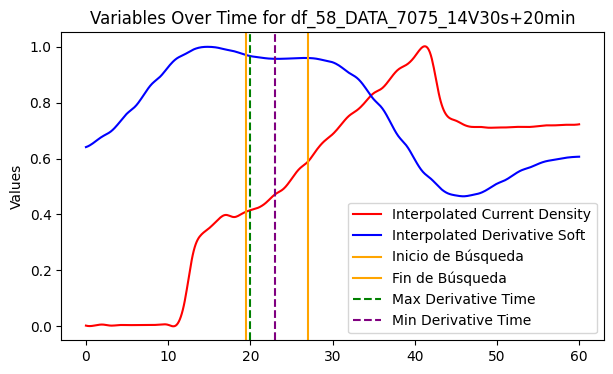

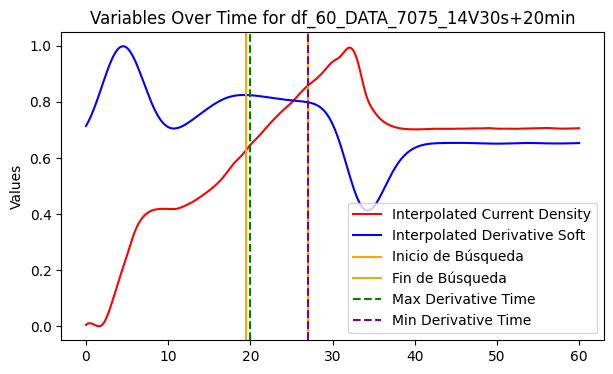

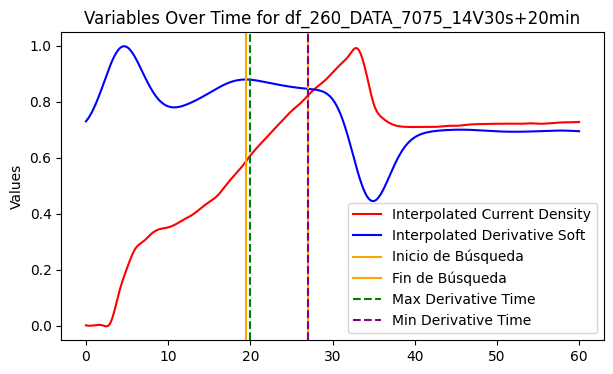

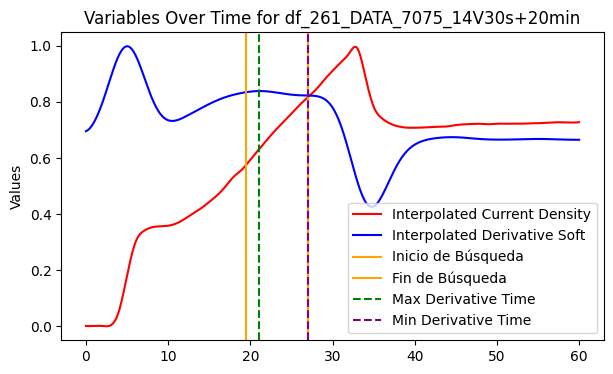

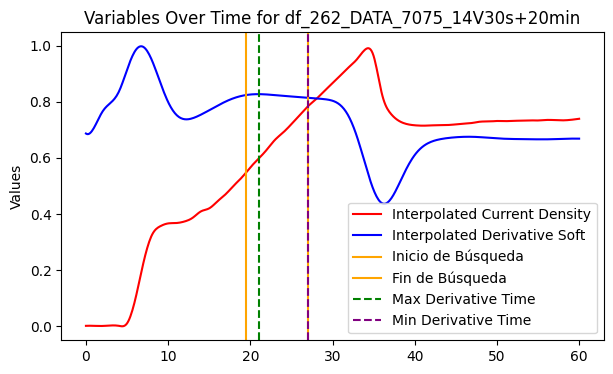

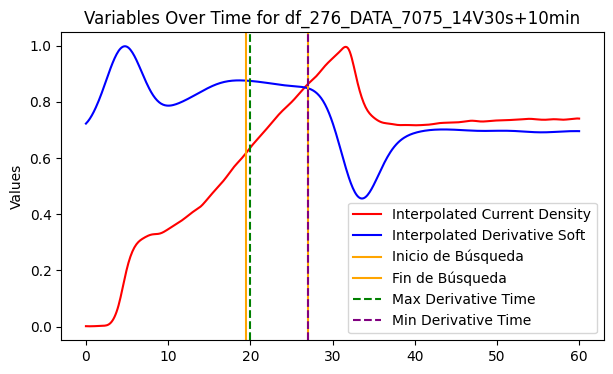

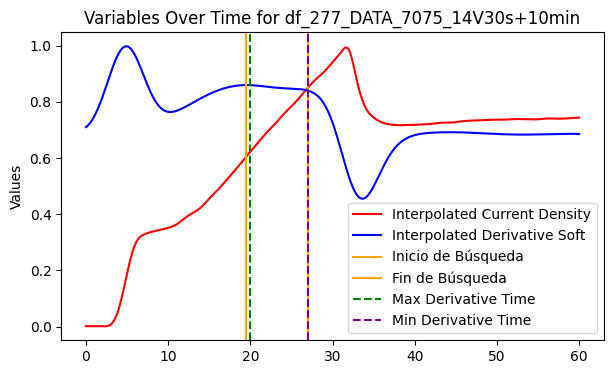

In [236]:
# Llamada a la función con el diccionario de DataFrames y los tiempos de inicio y fin
graficar_dataframes(resultados_14V30s, 19.5, 27)

In [241]:
def transferir_y_rellenar(dataframes_originales, dataframes_modificados):
    """
    Transfiere las columnas Time_seg_max_derivative y Time_seg_min_derivative
    de dataframes_modificados a dataframes_originales y rellena los valores faltantes.

    Parámetros:
    dataframes_originales: Diccionario original de DataFrames.
    dataframes_modificados: Diccionario de DataFrames con las columnas añadidas.
    """
    for var_name, df_modificado in dataframes_modificados.items():
        # Comprobar si el DataFrame está en ambos diccionarios
        if var_name in dataframes_originales:
            df_original = dataframes_originales[var_name]

            # Añadir las columnas a dataframes_originales
            max_time = df_modificado['Time_seg_max_derivative'].iloc[0]
            min_time = df_modificado['Time_seg_min_derivative'].iloc[0]
            
            df_original['Time_seg_max_derivative'] = max_time
            df_original['Time_seg_min_derivative'] = min_time

In [242]:
# Aplicar la función
transferir_y_rellenar(inicial_14V30s , resultados_14V30s)

In [ ]:
# Uso de la función con el diccionario 'inicial_14V30s'
visualizar_primeras_filas(inicial_14V30s)

### 16V30s

In [252]:
# Cargamos los dataframes en el diccionario
file_to_var_mapping_16V30s = {
    "263_DATA_7075_16V30s+20min.csv": "df_263_DATA_7075_16V30s+20min",
    "264_DATA_7075_16V30s+20min.csv": "df_264_DATA_7075_16V30s+20min",
    "265_DATA_7075_16V30s+20min.csv": "df_265_DATA_7075_16V30s+20min",
    #"278_DATA_7075_16V30s+10min.csv": "df_278_DATA_7075_16V30s+10min",
    "279_DATA_7075_16V30s+10min.csv": "df_279_DATA_7075_16V30s+10min",
    #"280_DATA_7075_16V30s+10min.csv": "df_280_DATA_7075_16V30s+10min"
 }

# Crear un diccionario inicial para almacenar los DataFrames
inicial_16V30s = {}

# Leer cada archivo y almacenar su contenido en un DataFrame
for filepath, var_name in file_to_var_mapping_16V30s.items():
    df = pd.read_csv(filepath)
    inicial_16V30s[var_name] = df

In [253]:
# Uso de la función 'procesar_archivos' de todos los dataframes
resultados_16V30s = procesar_archivos(file_to_var_mapping_16V30s, 60, 19, 27) # Aquí puedes variar el valor de tiempo_limite

In [ ]:
# Uso de la función con el diccionario 'resultados_16V30s'
visualizar_primeras_filas(resultados_16V30s)

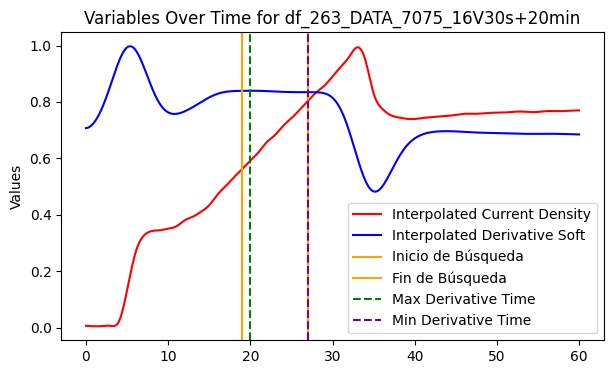

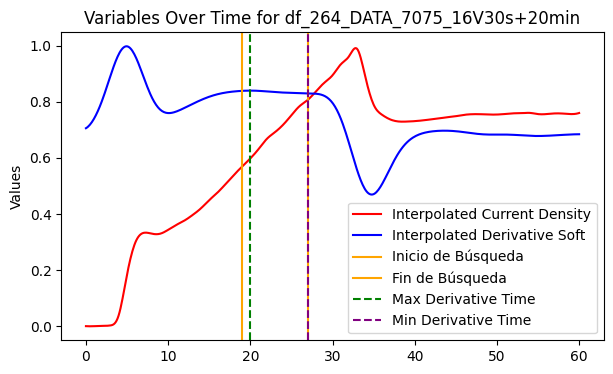

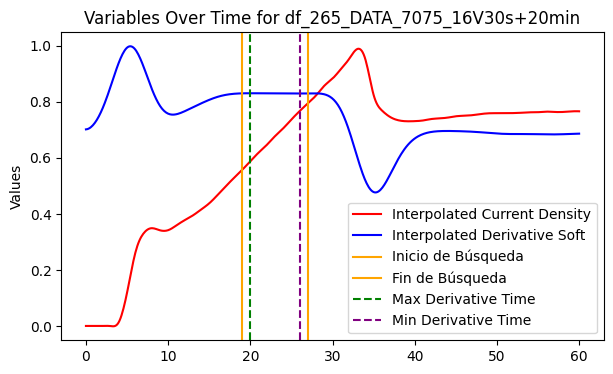

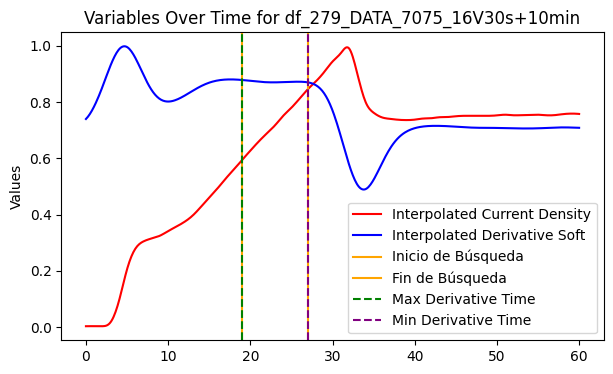

In [255]:
# Llamada a la función con el diccionario de DataFrames y los tiempos de inicio y fin
graficar_dataframes(resultados_16V30s, 19, 27)

In [256]:
# Aplicar la función
transferir_y_rellenar(inicial_16V30s , resultados_16V30s)

In [ ]:
# Uso de la función con el diccionario 'inicial_16V30s'
visualizar_primeras_filas(inicial_16V30s)

### 18v30s

In [262]:
# Cargamos los dataframes en el diccionario
file_to_var_mapping_18V30s = {
    # "266_DATA_7075_18V30s+20min.csv": "df_266_DATA_7075_18V30s+20min",
    # "267_DATA_7075_18V30s+20min.csv": "df_267_DATA_7075_18V30s+20min",
    # "268_DATA_7075_18V30s+20min.csv": "df_268_DATA_7075_18V30s+20min",
    # "281_DATA_7075_18V30s+10min.csv": "df_281_DATA_7075_18V30s+10min",
    # "282_DATA_7075_18V30s+10min.csv": "df_282_DATA_7075_18V30s+10min",
    # "283_DATA_7075_18V30s+10min.csv": "df_283_DATA_7075_18V30s+10min"
 }

# Crear un diccionario inicial para almacenar los DataFrames
inicial_18V30s = {}

# Leer cada archivo y almacenar su contenido en un DataFrame
for filepath, var_name in file_to_var_mapping_18V30s.items():
    df = pd.read_csv(filepath)
    inicial_18V30s[var_name] = df

In [263]:
# Uso de la función 'procesar_archivos' de todos los dataframes
resultados_18V30s = procesar_archivos(file_to_var_mapping_18V30s, 60, 19.5, 27) # Aquí puedes variar el valor de tiempo_limite

In [264]:
# Uso de la función con el diccionario 'resultados_18V30s'
visualizar_primeras_filas(resultados_18V30s)

In [265]:
# Llamada a la función con el diccionario de DataFrames y los tiempos de inicio y fin
graficar_dataframes(resultados_18V30s, 19.5, 27)

In [266]:
# Aplicar la función
transferir_y_rellenar(inicial_18V30s , resultados_18V30s)

In [267]:
# Uso de la función con el diccionario 'inicial_18V30s'
visualizar_primeras_filas(inicial_18V30s)

### 20v30s

In [279]:
# Cargamos los dataframes en el diccionario
file_to_var_mapping_20V30s = {
    "51_DATA_7075_20V30s+20min.csv": "df_51_DATA_7075_20V30s+20min",
    #"52_DATA_7075_20V30s+20min.csv": "df_52_DATA_7075_20V30s+20min", Todos los que estan comentados que son 213, 221, 249, 271, 272, 273, 274 no tienen datos
    #"150_DATA_7075_20V30s+20min.csv": "df_150_DATA_7075_20V30s+20min",
    #"151_DATA_7075_20V30s+20min.csv": "df_151_DATA_7075_20V30s+20min",
    "152_DATA_7075_20V30s+20min.csv": "df_152_DATA_7075_20V30s+20min",
    #"269_DATA_7075_20V30s+20min.csv": "df_269_DATA_7075_20V30s+20min",
    #"270_DATA_7075_20V30s+20min.csv": "df_270_DATA_7075_20V30s+20min",
    #"271_DATA_7075_20V30s+20min.csv": "df_271_DATA_7075_20V30s+20min", Todos los que estan comentados que son 213, 221, 249, 271, 272, 273, 274 no tienen datos
    #"284_DATA_7075_20V30s+10min.csv": "df_284_DATA_7075_20V30s+10min",
    #"285_DATA_7075_20V30s+10min.csv": "df_285_DATA_7075_20V30s+10min",
    #"286_DATA_7075_20V30s+10min.csv": "df_286_DATA_7075_20V30s+10min"
 }
# Crear un diccionario inicial para almacenar los DataFrames
inicial_20V30s = {}

# Leer cada archivo y almacenar su contenido en un DataFrame
for filepath, var_name in file_to_var_mapping_20V30s.items():
    df = pd.read_csv(filepath)
    inicial_20V30s[var_name] = df

In [280]:
# Uso de la función 'procesar_archivos' de todos los dataframes
resultados_20V30s = procesar_archivos(file_to_var_mapping_20V30s, 60, 19.5, 27) # Aquí puedes variar el valor de tiempo_limite

In [ ]:
# Uso de la función con el diccionario 'resultados_20V30s'
visualizar_primeras_filas(resultados_20V30s)

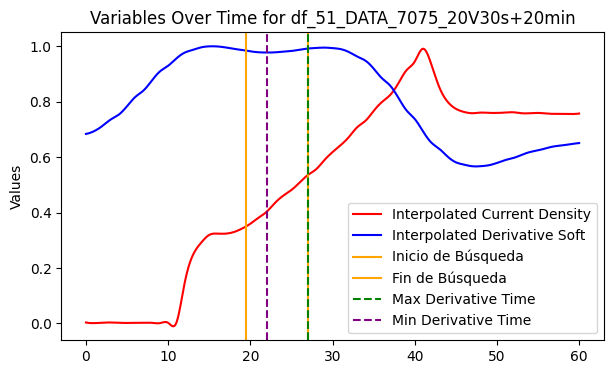

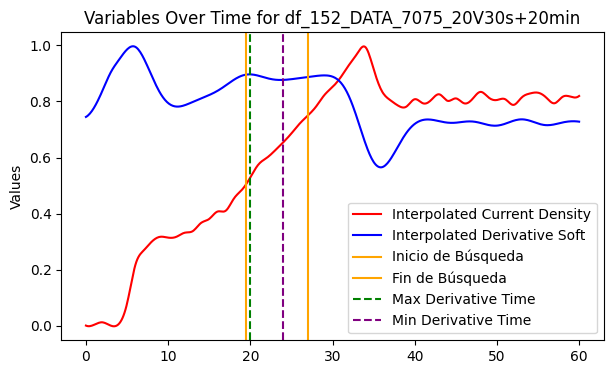

In [282]:
# Llamada a la función con el diccionario de DataFrames y los tiempos de inicio y fin
graficar_dataframes(resultados_20V30s, 19.5, 27)

In [283]:
# Aplicar la función
transferir_y_rellenar(inicial_20V30s , resultados_20V30s)

In [ ]:
# Uso de la función con el diccionario 'inicial_20V30s'
visualizar_primeras_filas(inicial_20V30s)

### 22v30s

In [288]:
# Cargamos los dataframes en el diccionario
file_to_var_mapping_22V30s = {
    #"272_DATA_7075_22V30s+20min.csv": "df_272_DATA_7075_22V30s+20min", Todos los que estan comentados que son 213, 221, 249, 271, 272, 273, 274 no tienen datos
    #"273_DATA_7075_22V30s+20min.csv": "df_273_DATA_7075_22V30s+20min", Todos los que estan comentados que son 213, 221, 249, 271, 272, 273, 274 no tienen datos
    #"274_DATA_7075_22V30s+20min.csv": "df_274_DATA_7075_22V30s+20min", Todos los que estan comentados que son 213, 221, 249, 271, 272, 273, 274 no tienen datos
    #"287_DATA_7075_22V30s+10min.csv": "df_287_DATA_7075_22V30s+10min",
    #"288_DATA_7075_22V30s+10min.csv": "df_288_DATA_7075_22V30s+10min",
    #"289_DATA_7075_22V30s+10min.csv": "df_289_DATA_7075_22V30s+10min"
 }

# Crear un diccionario inicial para almacenar los DataFrames
inicial_22V30s = {}

# Leer cada archivo y almacenar su contenido en un DataFrame
for filepath, var_name in file_to_var_mapping_22V30s.items():
    df = pd.read_csv(filepath)
    inicial_22V30s[var_name] = df

In [289]:
# Uso de la función 'procesar_archivos' de todos los dataframes
resultados_22V30s = procesar_archivos(file_to_var_mapping_22V30s, 60, 19.5, 27) # Aquí puedes variar el valor de tiempo_limite

In [290]:
# Uso de la función con el diccionario 'resultados_22V30s'
visualizar_primeras_filas(resultados_22V30s)

In [291]:
# Llamada a la función con el diccionario de DataFrames y los tiempos de inicio y fin
graficar_dataframes(resultados_22V30s, 19.5, 27)

In [292]:
# Aplicar la función
transferir_y_rellenar(inicial_22V30s , resultados_22V30s)

In [293]:
# Uso de la función con el diccionario 'inicial_22V30s'
visualizar_primeras_filas(inicial_22V30s)

# 60 Segundos

### 14v60s

In [316]:
# Cargamos los dataframes en el diccionario
file_to_var_mapping_14V60s = {
    "55_DATA_7075_14V60s+20min.csv": "df_55_DATA_7075_14V60s+20min",
    "57_DATA_7075_14V60s+20min.csv": "df_57_DATA_7075_14V60s+20min",
    #"141_DATA_7075_14V60s+20min.csv": "df_141_DATA_7075_14V60s+20min",
    #"142_DATA_7075_14V60s+20min.csv": "df_142_DATA_7075_14V60s+20min",
    #"143_DATA_7075_14V60s+20min.csv": "df_143_DATA_7075_14V60s+20min",
    #"162_DATA_7075_14V60s+10min.csv": "df_162_DATA_7075_14V60s+10min",
    #"163_DATA_7075_14V60s+10min.csv": "df_163_DATA_7075_14V60s+10min",
    #"164_DATA_7075_14V60s+10min.csv": "df_164_DATA_7075_14V60s+10min",
    #"190_DATA_7075_14V60s+5min.csv": "df_190_DATA_7075_14V60s+5min",
    #"191_DATA_7075_14V60s+5min.csv": "df_191_DATA_7075_14V60s+5min",
    #"192_DATA_7075_14V60s+5min.csv": "df_192_DATA_7075_14V60s+5min",
    #"205_DATA_7075_14V60s+0min.csv": "df_205_DATA_7075_14V60s+0min", 
    #"206_DATA_7075_14V60s+0min.csv": "df_206_DATA_7075_14V60s+0min", 
    #"207_DATA_7075_14V60s+0min.csv": "df_207_DATA_7075_14V60s+0min", 
    #"220_DATA_7075_14V60s+20min.csv": "df_220_DATA_7075_14V60s+20min",
    #"221_DATA_7075_14V60s+20min.csv": "df_221_DATA_7075_14V60s+20min", Todos los que estan comentados que son 213, 221, 249, 271, 272, 273, 274 no tienen datos
    #"226_DATA_7075_14V60s+10min.csv": "df_226_DATA_7075_14V60s+10min",
    #"231_DATA_7075_14V60s+1min.csv": "df_231_DATA_7075_14V60s+1min",
    #"232_DATA_7075_14V60s+1min.csv": "df_232_DATA_7075_14V60s+1min",
    #"233_DATA_7075_14V60s+1min.csv": "df_233_DATA_7075_14V60s+1min"
 }

# Crear un diccionario inicial para almacenar los DataFrames
inicial_14V60s = {}

# Leer cada archivo y almacenar su contenido en un DataFrame
for filepath, var_name in file_to_var_mapping_14V60s.items():
    df = pd.read_csv(filepath)
    inicial_14V60s[var_name] = df

In [317]:
# Uso de la función 'procesar_archivos' de todos los dataframes
resultados_14V60s = procesar_archivos(file_to_var_mapping_14V60s, 80, 38, 58) # Aquí puedes variar el valor de tiempo_limite

In [ ]:
# Uso de la función con el diccionario 'resultados_14V60s'
visualizar_primeras_filas(resultados_14V60s)

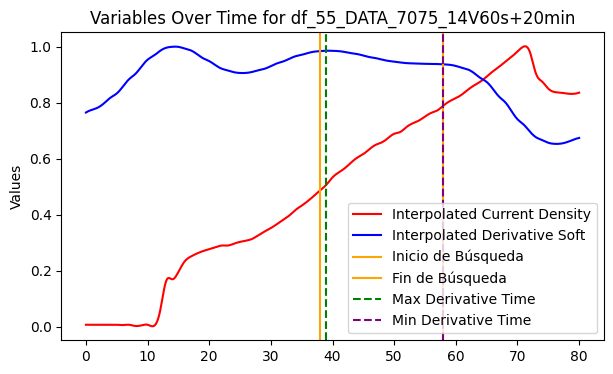

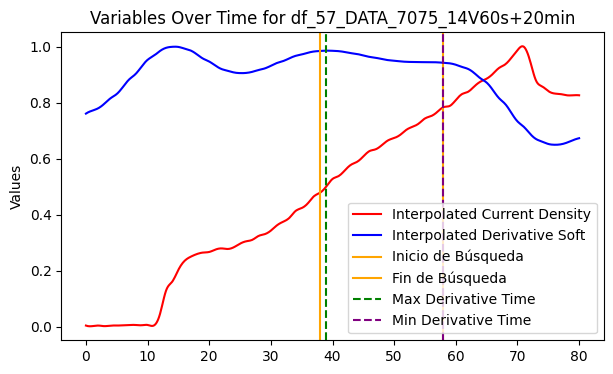

In [318]:
# Llamada a la función con el diccionario de DataFrames y los tiempos de inicio y fin
graficar_dataframes(resultados_14V60s, 38, 58)

In [319]:
# Aplicar la función
transferir_y_rellenar(inicial_14V60s , resultados_14V60s)

In [ ]:
# Uso de la función con el diccionario 'inicial_14V60s'
visualizar_primeras_filas(inicial_14V60s)

### 16v60s

In [325]:
# Cargamos los dataframes en el diccionario
file_to_var_mapping_16V60s = {
    "153_DATA_7075_16V60s+20min.csv": "df_153_DATA_7075_16V60s+20min",
    #"154_DATA_7075_16V60s+20min.csv": "df_154_DATA_7075_16V60s+20min", Todos los que estan comentados que son 213, 221, 249, 271, 272, 273, 274 no tienen datos
    #"155_DATA_7075_16V60s+20min.csv": "df_155_DATA_7075_16V60s+20min",
    "165_DATA_7075_16V60s+10min.csv": "df_165_DATA_7075_16V60s+10min",
    "166_DATA_7075_16V60s+10min.csv": "df_166_DATA_7075_16V60s+10min",
    "167_DATA_7075_16V60s+10min.csv": "df_167_DATA_7075_16V60s+10min",
    "193_DATA_7075_16V60s+5min.csv": "df_193_DATA_7075_16V60s+5min",
    "194_DATA_7075_16V60s+5min.csv": "df_194_DATA_7075_16V60s+5min",
    "195_DATA_7075_16V60s+5min.csv": "df_195_DATA_7075_16V60s+5min",
    "208_DATA_7075_16V60s+0min.csv": "df_208_DATA_7075_16V60s+0min",
    "209_DATA_7075_16V60s+0min.csv": "df_209_DATA_7075_16V60s+0min",
    "210_DATA_7075_16V60s+0min.csv": "df_210_DATA_7075_16V60s+0min",
    #"222_DATA_7075_16V60s+20min.csv": "df_222_DATA_7075_16V60s+20min",
    #"227_DATA_7075_16V60s+10min.csv": "df_227_DATA_7075_16V60s+10min",
    #"234_DATA_7075_16V60s+1min.csv": "df_234_DATA_7075_16V60s+1min",
    #"235_DATA_7075_16V60s+1min.csv": "df_235_DATA_7075_16V60s+1min",
    #"236_DATA_7075_16V60s+1min.csv": "df_236_DATA_7075_16V60s+1min",
    "247_DATA_7075_16V60s+10min.csv": "df_247_DATA_7075_16V60s+10min"
}

# Crear un diccionario inicial para almacenar los DataFrames
inicial_16V60s = {}

# Leer cada archivo y almacenar su contenido en un DataFrame
for filepath, var_name in file_to_var_mapping_16V60s.items():
    df = pd.read_csv(filepath)
    inicial_16V60s[var_name] = df

In [326]:
# Uso de la función 'procesar_archivos' de todos los dataframes
resultados_16V60s = procesar_archivos(file_to_var_mapping_16V60s, 80, 25, 40) # Aquí puedes variar el valor de tiempo_limite

In [ ]:
# Uso de la función con el diccionario 'resultados_16V60s'
visualizar_primeras_filas(resultados_16V60s)

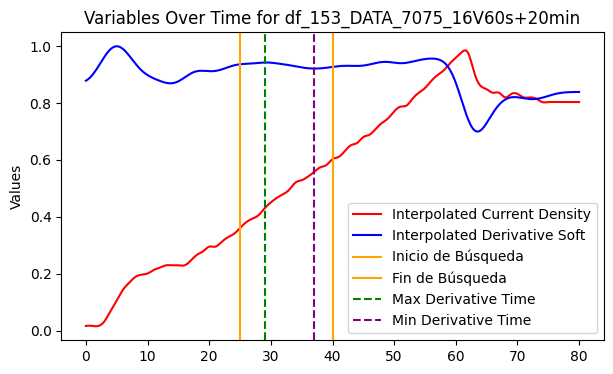

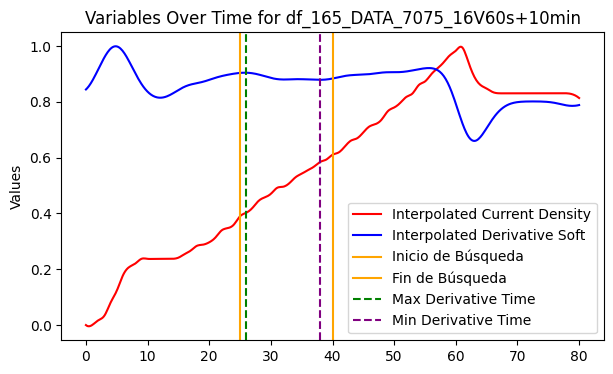

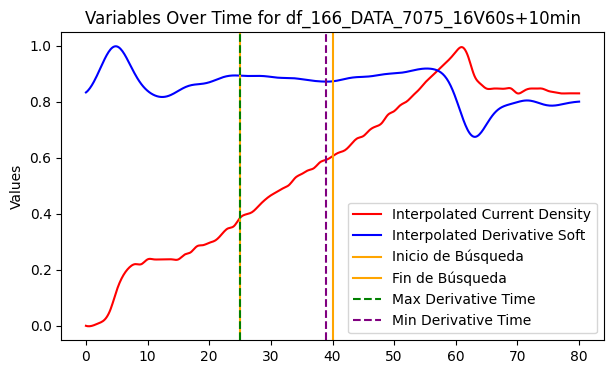

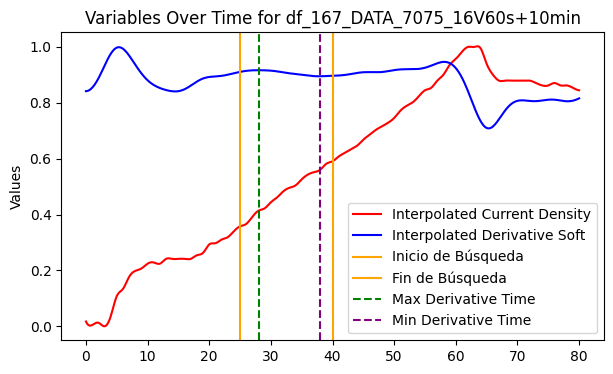

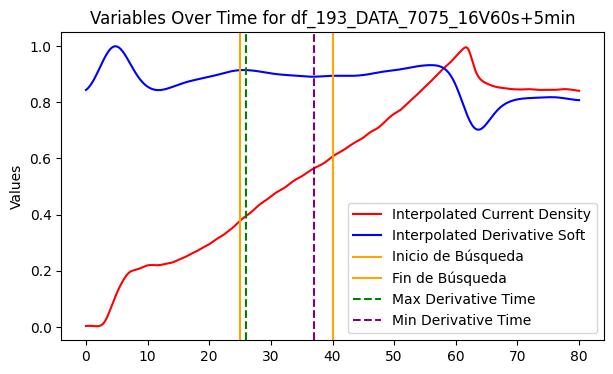

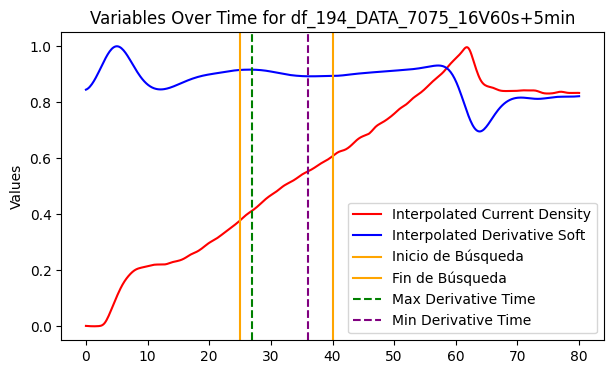

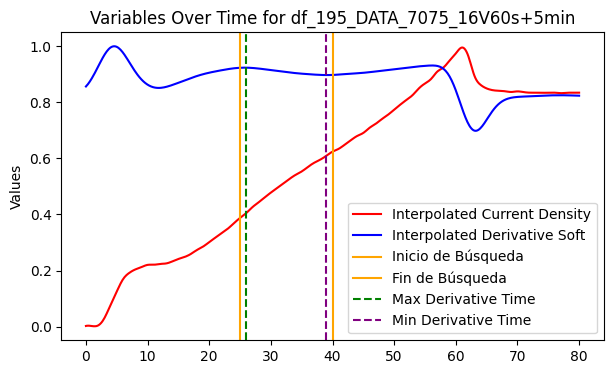

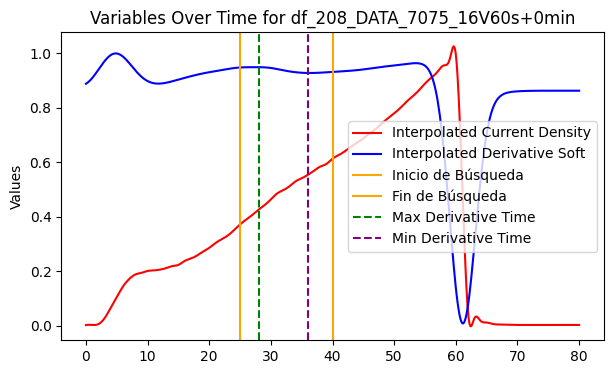

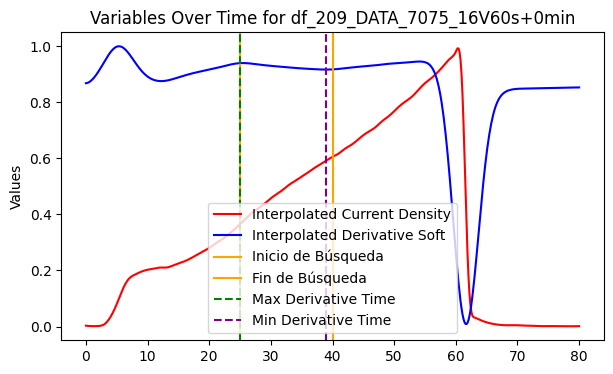

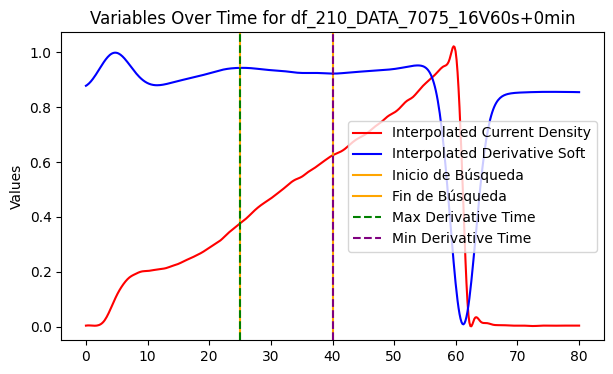

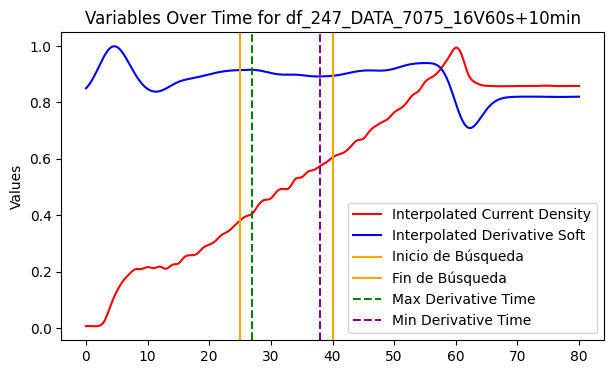

In [328]:
# Llamada a la función con el diccionario de DataFrames y los tiempos de inicio y fin
graficar_dataframes(resultados_16V60s, 25, 40)

In [329]:
# Aplicar la función
transferir_y_rellenar(inicial_16V60s , resultados_16V60s)

In [ ]:
# Uso de la función con el diccionario 'inicial_16V60s'
visualizar_primeras_filas(inicial_16V60s)

### 18v60s

In [372]:
# Cargamos los dataframes en el diccionario
file_to_var_mapping_18V60s = {
    #"156_DATA_7075_18V60s+20min.csv": "df_156_DATA_7075_18V60s+20min",
    #"157_DATA_7075_18V60s+20min.csv": "df_157_DATA_7075_18V60s+20min",
    #"158_DATA_7075_18V60s+20min.csv": "df_158_DATA_7075_18V60s+20min",
    #"168_DATA_7075_18V60s+10min.csv": "df_168_DATA_7075_18V60s+10min",
    #"171_DATA_7075_18V60s+10min.csv": "df_171_DATA_7075_18V60s+10min",
    #"172_DATA_7075_18V60s+10min.csv": "df_172_DATA_7075_18V60s+10min",
    "196_DATA_7075_18V60s+5min.csv": "df_196_DATA_7075_18V60s+5min",
    "197_DATA_7075_18V60s+5min.csv": "df_197_DATA_7075_18V60s+5min",
    "198_DATA_7075_18V60s+5min.csv": "df_198_DATA_7075_18V60s+5min",
    "211_DATA_7075_18V60s+0min.csv": "df_211_DATA_7075_18V60s+0min",
    "212_DATA_7075_18V60s+0min.csv": "df_212_DATA_7075_18V60s+0min",
    #"213_DATA_7075_18V60s+0min.csv": "df_213_DATA_7075_18V60s+0min", Todos los que estan comentados que son 213, 221, 249, 271, 272, 273, 274 no tienen datos
    "223_DATA_7075_18V60s+20min.csv": "df_223_DATA_7075_18V60s+20min",
    #"228_DATA_7075_18V60s+10min.csv": "df_228_DATA_7075_18V60s+10min",
    #"237_DATA_7075_18V60s+1min.csv": "df_237_DATA_7075_18V60s+1min",
    #"249_DATA_7075_18V60s+1min.csv": "df_249_DATA_7075_18V60s+1min", Todos los que estan comentados que son 213, 221, 249, 271, 272, 273, 274 no tienen datos
    #"250_DATA_7075_18V60s+1min.csv": "df_250_DATA_7075_18V60s+1min" 
}

# Crear un diccionario inicial para almacenar los DataFrames
inicial_18V60s = {}

# Leer cada archivo y almacenar su contenido en un DataFrame
for filepath, var_name in file_to_var_mapping_18V60s.items():
    df = pd.read_csv(filepath)
    inicial_18V60s[var_name] = df

In [373]:
# Uso de la función 'procesar_archivos' de todos los dataframes
resultados_18V60s = procesar_archivos(file_to_var_mapping_18V60s, 60, 22, 40) # Aquí puedes variar el valor de tiempo_limite

In [ ]:
# Uso de la función con el diccionario 'resultados_18V60s'
visualizar_primeras_filas(resultados_18V60s)

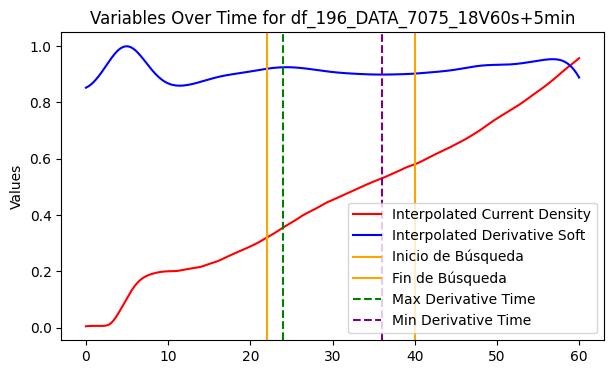

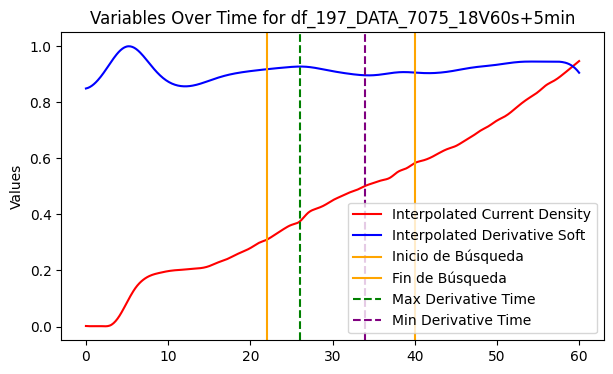

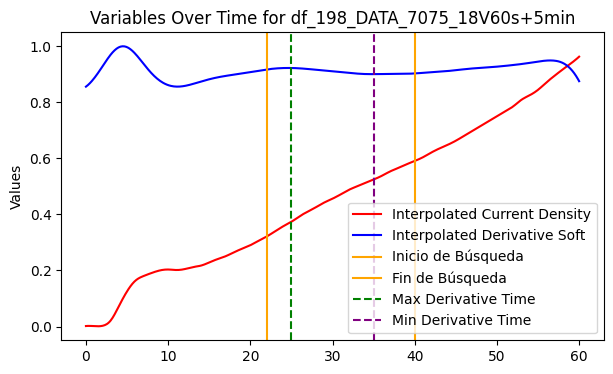

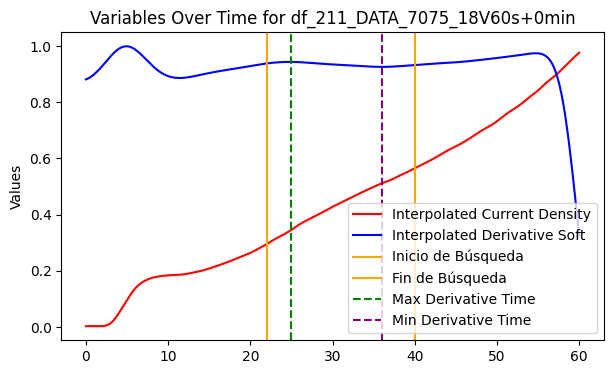

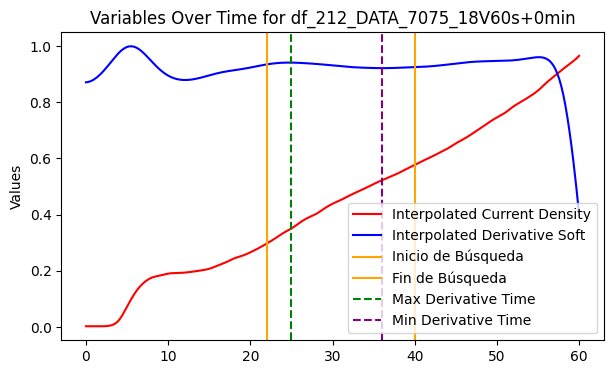

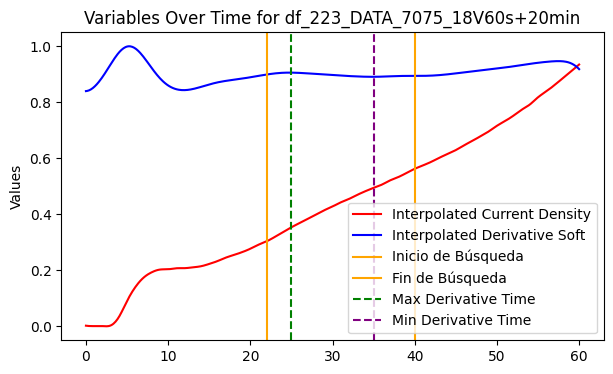

In [374]:
# Llamada a la función con el diccionario de DataFrames y los tiempos de inicio y fin
graficar_dataframes(resultados_18V60s, 22, 40)

In [375]:
# Aplicar la función
transferir_y_rellenar(inicial_18V60s , resultados_18V60s)

In [ ]:
# Uso de la función con el diccionario 'inicial_18V60s'
visualizar_primeras_filas(inicial_18V60s)

### 20v60s

In [378]:
# Cargamos los dataframes en el diccionario
file_to_var_mapping_20V60s = {
    #"49_DATA_7075_20V60s+20min.csv": "df_49_DATA_7075_20V60s+20min",
    #"50_DATA_7075_20V60s+20min.csv": "df_50_DATA_7075_20V60s+20min",
    #"147_DATA_7075_20V60s+20min.csv": "df_147_DATA_7075_20V60s+20min",
    "148_DATA_7075_20V60s+20min.csv": "df_148_DATA_7075_20V60s+20min",
    #"149_DATA_7075_20V60s+20min.csv": "df_149_DATA_7075_20V60s+20min",
    #"180_DATA_7075_20V60s+10min.csv": "df_180_DATA_7075_20V60s+10min",
    #"181_DATA_7075_20V60s+10min.csv": "df_181_DATA_7075_20V60s+10min",
    #"182_DATA_7075_20V60s+10min.csv": "df_182_DATA_7075_20V60s+10min",
    "199_DATA_7075_20V60s+5min.csv": "df_199_DATA_7075_20V60s+5min",
    "200_DATA_7075_20V60s+5min.csv": "df_200_DATA_7075_20V60s+5min",
    "201_DATA_7075_20V60s+5min.csv": "df_201_DATA_7075_20V60s+5min",
    "214_DATA_7075_20V60s+0min.csv": "df_214_DATA_7075_20V60s+0min",
    "215_DATA_7075_20V60s+0min.csv": "df_215_DATA_7075_20V60s+0min",
    "216_DATA_7075_20V60s+0min.csv": "df_216_DATA_7075_20V60s+0min",
    "224_DATA_7075_20V60s+20min.csv": "df_224_DATA_7075_20V60s+20min",
    "229_DATA_7075_20V60s+10min.csv": "df_229_DATA_7075_20V60s+10min",
    #"238_DATA_7075_20V60s+1min.csv": "df_238_DATA_7075_20V60s+1min",
    #"239_DATA_7075_20V60s+1min.csv": "df_239_DATA_7075_20V60s+1min",
    "240_DATA_7075_20V60s+1min.csv": "df_240_DATA_7075_20V60s+1min"
}

# Crear un diccionario inicial para almacenar los DataFrames
inicial_20V60s = {}

# Leer cada archivo y almacenar su contenido en un DataFrame
for filepath, var_name in file_to_var_mapping_20V60s.items():
    df = pd.read_csv(filepath)
    inicial_20V60s[var_name] = df

In [381]:
# Uso de la función 'procesar_archivos' de todos los dataframes
resultados_20V60s = procesar_archivos(file_to_var_mapping_20V60s, 60, 22, 35) # Aquí puedes variar el valor de tiempo_limite

In [ ]:
# Uso de la función con el diccionario 'resultados_20V60s'
visualizar_primeras_filas(resultados_20V60s)

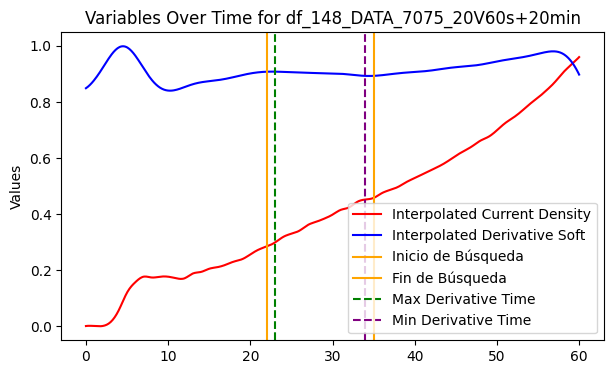

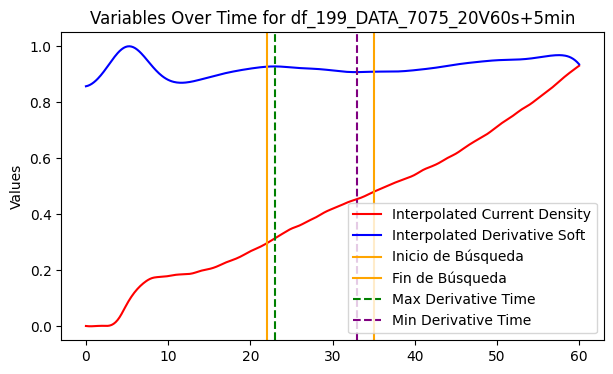

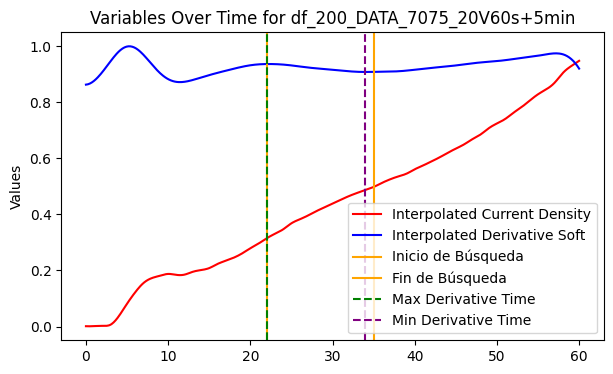

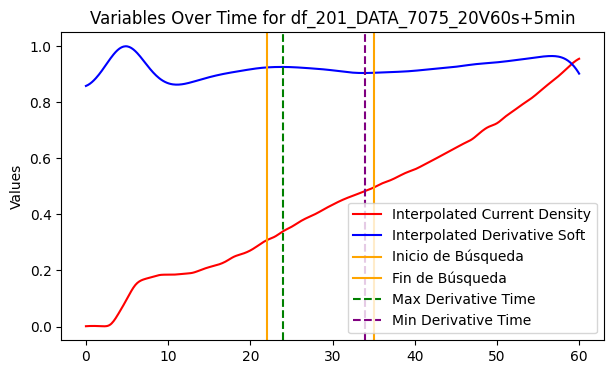

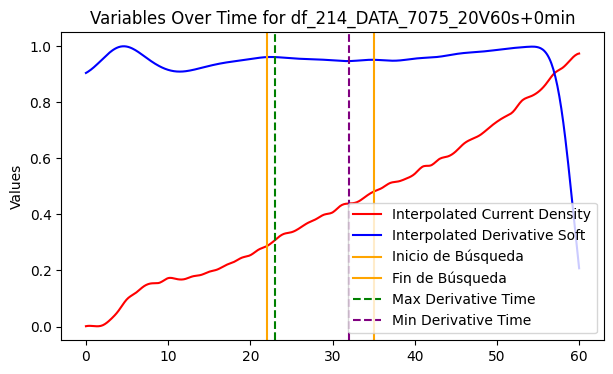

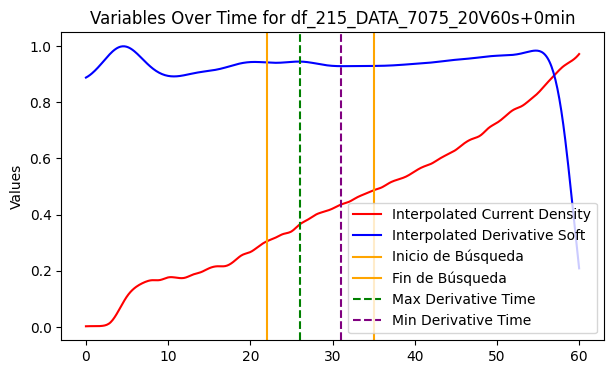

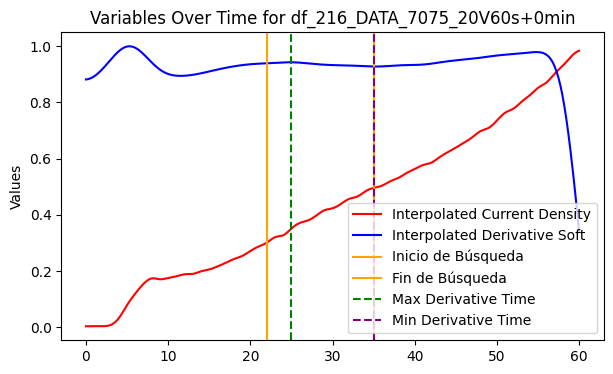

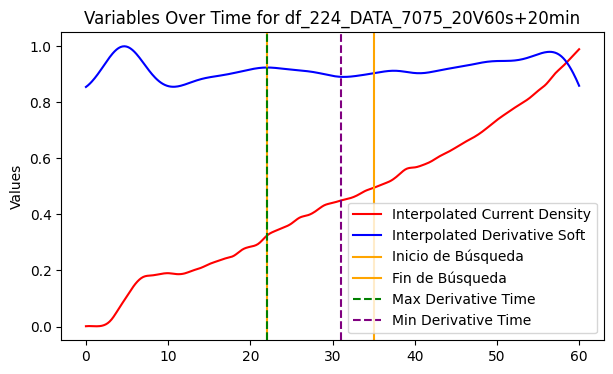

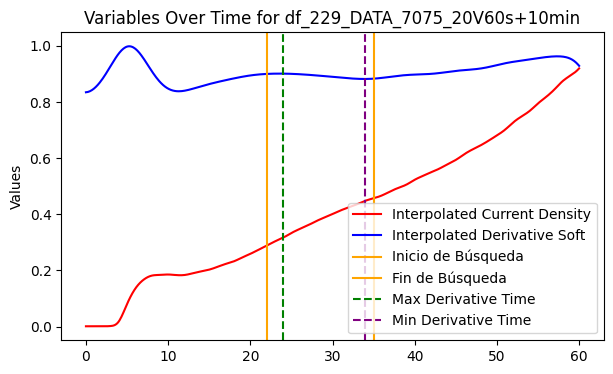

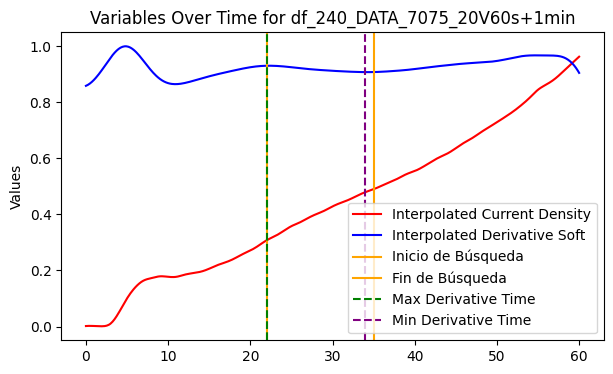

In [382]:
# Llamada a la función con el diccionario de DataFrames y los tiempos de inicio y fin
graficar_dataframes(resultados_20V60s, 22, 35)

In [383]:
# Aplicar la función
transferir_y_rellenar(inicial_20V60s , resultados_20V60s)

In [ ]:
# Uso de la función con el diccionario 'inicial_18V60s'
visualizar_primeras_filas(inicial_20V60s)

### 22v60s

In [406]:
# Cargamos los dataframes en el diccionario
file_to_var_mapping_22V60s = {
    #"159_DATA_7075_22V60s+20min.csv": "df_159_DATA_7075_22V60s+20min",
    #"160_DATA_7075_22V60s+20min.csv": "df_160_DATA_7075_22V60s+20min",
    #"161_DATA_7075_22V60s+20min.csv": "df_161_DATA_7075_22V60s+20min",
    "183_DATA_7075_22V60s+10min.csv": "df_183_DATA_7075_22V60s+10min",
    "184_DATA_7075_22V60s+10min.csv": "df_184_DATA_7075_22V60s+10min",
    #"185_DATA_7075_22V60s+10min.csv": "df_185_DATA_7075_22V60s+10min",
    #"202_DATA_7075_22V60s+5min.csv": "df_202_DATA_7075_22V60s+5min",
    #"203_DATA_7075_22V60s+5min.csv": "df_203_DATA_7075_22V60s+5min",
    "204_DATA_7075_22V60s+5min.csv": "df_204_DATA_7075_22V60s+5min",
    #"217_DATA_7075_22V60s+0min.csv": "df_217_DATA_7075_22V60s+0min",
    #"218_DATA_7075_22V60s+0min.csv": "df_218_DATA_7075_22V60s+0min",
    "219_DATA_7075_22V60s+0min.csv": "df_219_DATA_7075_22V60s+0min",
    #"225_DATA_7075_22V60s+20min.csv": "df_225_DATA_7075_22V60s+20min",
    #"230_DATA_7075_22V60s+10min.csv": "df_230_DATA_7075_22V60s+10min",
    #"241_DATA_7075_22V60s+1min.csv": "df_241_DATA_7075_22V60s+1min", Le hemos comentado ya que tiene un error en la corriente.
    "242_DATA_7075_22V60s+1min.csv": "df_242_DATA_7075_22V60s+1min",
    "243_DATA_7075_22V60s+1min.csv": "df_243_DATA_7075_22V60s+1min",
    "244_DATA_7075_22V60s+1min.csv": "df_244_DATA_7075_22V60s+1min",
    "245_DATA_7075_22V60s+20min.csv": "df_245_DATA_7075_22V60s+20min"
}

# Crear un diccionario inicial para almacenar los DataFrames
inicial_22V60s = {}

# Leer cada archivo y almacenar su contenido en un DataFrame
for filepath, var_name in file_to_var_mapping_22V60s.items():
    df = pd.read_csv(filepath)
    inicial_22V60s[var_name] = df

In [407]:
# Uso de la función 'procesar_archivos' de todos los dataframes
resultados_22V60s = procesar_archivos(file_to_var_mapping_22V60s, 60, 22, 34) # Aquí puedes variar el valor de tiempo_limite

In [408]:
# Uso de la función con el diccionario 'resultados_22V60s'
visualizar_primeras_filas(resultados_22V60s)

"Primeras filas del DataFrame 'df_183_DATA_7075_22V60s+10min':"

,Time,current_density,soft_current_density,derivative_soft,Time_seg,Time_seg_max_derivative,Time_seg_min_derivative
566,2023-07-14 10:00:11,0.003027,0.004349,0.849522,0.0,25.0,33.0
567,2023-07-14 10:00:11,0.003027,0.005135,0.853450,0.0,25.0,33.0
568,2023-07-14 10:00:12,0.003027,0.006123,0.858120,1.0,25.0,33.0
569,2023-07-14 10:00:12,0.003027,0.007349,0.863589,1.0,25.0,33.0
570,2023-07-14 10:00:12,0.003027,0.008852,0.869897,1.0,25.0,33.0


"Primeras filas del DataFrame 'df_184_DATA_7075_22V60s+10min':"

,Time,current_density,soft_current_density,derivative_soft,Time_seg,Time_seg_max_derivative,Time_seg_min_derivative
285,2023-07-14 10:18:01,0.00202,0.003506,0.853607,0.0,22.0,31.0
286,2023-07-14 10:18:01,0.00202,0.004399,0.858039,0.0,22.0,31.0
287,2023-07-14 10:18:01,0.00202,0.005521,0.863243,0.0,22.0,31.0
288,2023-07-14 10:18:02,0.00000,0.006909,0.869257,1.0,22.0,31.0
289,2023-07-14 10:18:02,0.00202,0.008604,0.876102,1.0,22.0,31.0


"Primeras filas del DataFrame 'df_204_DATA_7075_22V60s+5min':"

,Time,current_density,soft_current_density,derivative_soft,Time_seg,Time_seg_max_derivative,Time_seg_min_derivative
160,2023-09-01 07:54:30,0.001021,0.002670,0.859427,0.0,23.0,33.0
161,2023-09-01 07:54:30,0.000000,0.003321,0.862760,0.0,23.0,33.0
162,2023-09-01 07:54:30,0.000000,0.004153,0.866800,0.0,23.0,33.0
163,2023-09-01 07:54:30,0.000000,0.005200,0.871610,0.0,23.0,33.0
164,2023-09-01 07:54:31,0.000000,0.006503,0.877240,1.0,23.0,33.0


"Primeras filas del DataFrame 'df_219_DATA_7075_22V60s+0min':"

,Time,current_density,soft_current_density,derivative_soft,Time_seg,Time_seg_max_derivative,Time_seg_min_derivative
965,2023-09-01 11:30:40,0.001947,0.003842,0.874512,0.0,22.0,31.0
966,2023-09-01 11:30:40,0.001947,0.004638,0.877820,0.0,22.0,31.0
967,2023-09-01 11:30:40,0.001947,0.005653,0.881829,0.0,22.0,31.0
968,2023-09-01 11:30:40,0.001947,0.006929,0.886601,0.0,22.0,31.0
969,2023-09-01 11:30:41,0.001947,0.008514,0.892175,1.0,22.0,31.0


"Primeras filas del DataFrame 'df_242_DATA_7075_22V60s+1min':"

,Time,current_density,soft_current_density,derivative_soft,Time_seg,Time_seg_max_derivative,Time_seg_min_derivative
143,2023-09-06 12:28:30,0.000971,0.002692,0.859982,0.0,22.0,32.0
144,2023-09-06 12:28:30,0.000971,0.003318,0.863638,0.0,22.0,32.0
145,2023-09-06 12:28:30,0.000000,0.004134,0.868013,0.0,22.0,32.0
146,2023-09-06 12:28:31,0.000000,0.005175,0.873160,1.0,22.0,32.0
147,2023-09-06 12:28:31,0.000000,0.006478,0.879115,1.0,22.0,32.0


"Primeras filas del DataFrame 'df_243_DATA_7075_22V60s+1min':"

,Time,current_density,soft_current_density,derivative_soft,Time_seg,Time_seg_max_derivative,Time_seg_min_derivative
248,2023-09-06 12:33:52,0.001,0.002033,0.855998,0.0,22.0,30.0
249,2023-09-06 12:33:52,0.001,0.002639,0.859293,0.0,22.0,30.0
250,2023-09-06 12:33:52,0.001,0.003418,0.863301,0.0,22.0,30.0
251,2023-09-06 12:33:52,0.001,0.004407,0.868096,0.0,22.0,30.0
252,2023-09-06 12:33:53,0.001,0.005644,0.873736,1.0,22.0,30.0


"Primeras filas del DataFrame 'df_244_DATA_7075_22V60s+1min':"

,Time,current_density,soft_current_density,derivative_soft,Time_seg,Time_seg_max_derivative,Time_seg_min_derivative
120,2023-09-12 10:15:42,0.001626,0.005448,0.836773,0.0,24.0,34.0
121,2023-09-12 10:15:42,0.001626,0.006569,0.842212,0.0,24.0,34.0
122,2023-09-12 10:15:42,0.001626,0.007949,0.848523,0.0,24.0,34.0
123,2023-09-12 10:15:42,0.001626,0.009626,0.855733,0.0,24.0,34.0
124,2023-09-12 10:15:43,0.001626,0.011642,0.863842,1.0,24.0,34.0


"Primeras filas del DataFrame 'df_245_DATA_7075_22V60s+20min':"

,Time,current_density,soft_current_density,derivative_soft,Time_seg,Time_seg_max_derivative,Time_seg_min_derivative
144,2023-09-12 10:39:26,0.000997,0.002138,0.849757,0.0,22.0,31.0
145,2023-09-12 10:39:26,0.000000,0.002782,0.853380,0.0,22.0,31.0
146,2023-09-12 10:39:26,0.000997,0.003604,0.857737,0.0,22.0,31.0
147,2023-09-12 10:39:26,0.000997,0.004640,0.862902,0.0,22.0,31.0
148,2023-09-12 10:39:27,0.000997,0.005926,0.868929,1.0,22.0,31.0


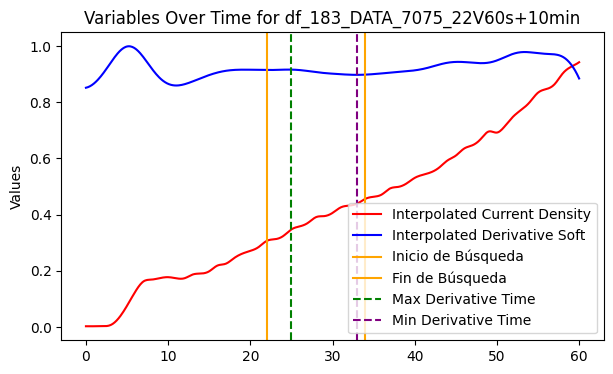

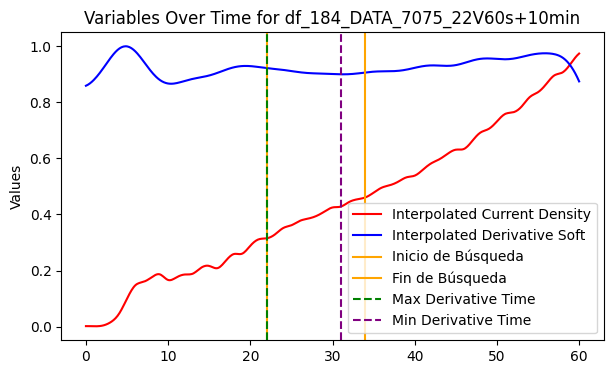

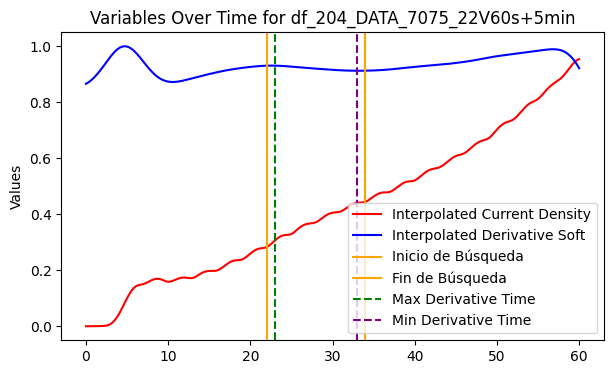

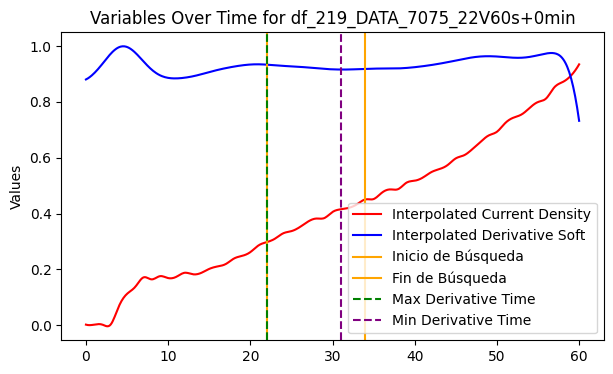

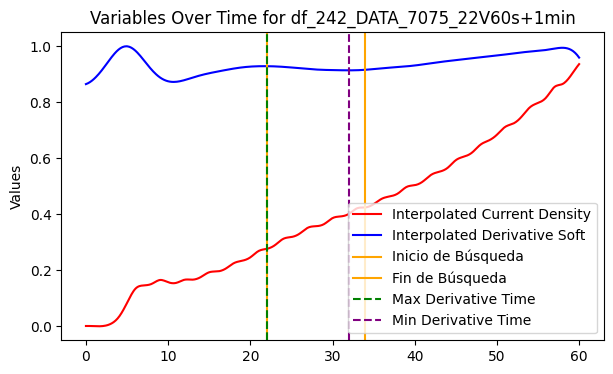

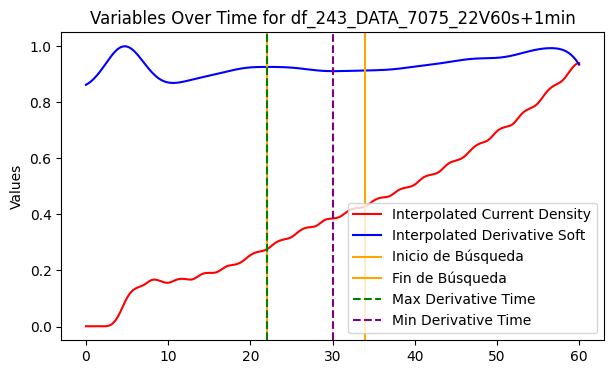

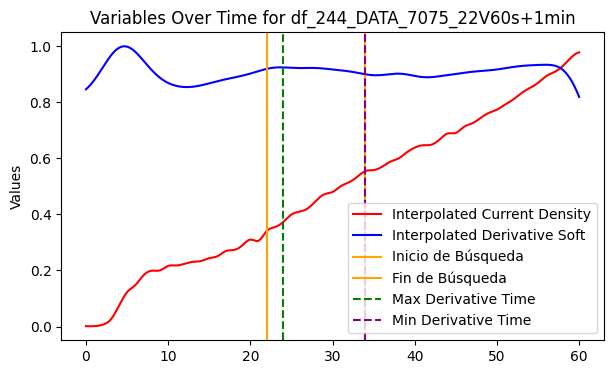

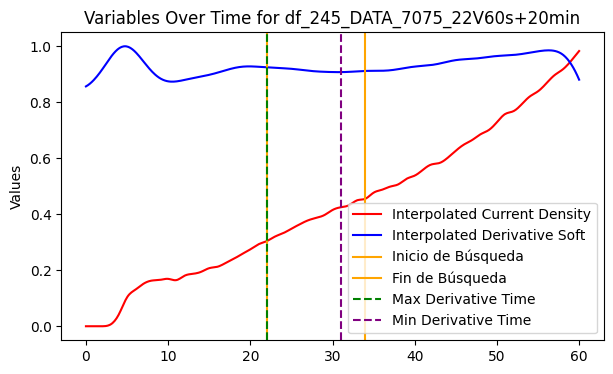

In [400]:
# Llamada a la función con el diccionario de DataFrames y los tiempos de inicio y fin
graficar_dataframes(resultados_22V60s, 22, 34)

In [401]:
# Aplicar la función
transferir_y_rellenar(inicial_22V60s , resultados_22V60s)

In [402]:
# Uso de la función con el diccionario 'inicial_22V60s'
visualizar_primeras_filas(inicial_22V60s)

"Primeras filas del DataFrame 'df_183_DATA_7075_22V60s+10min':"

,Id,Timestamp,Time,MS,V,A,MV,T,Area1,current_density,humidity,ambient_temperature,bath_pH,bath_conductivity,diameter,roughness_average_b,roughness_standard_deviation_b,alloy,voltage,ramp_time,holding_time,experiment_time,area,observations,thickness_average_a,thickness_standard_deviation_a,thickness_average_b,thickness_standard_deviation_b,roughness_average_a,roughness_standard_deviation_a,Time_seg_max_derivative,Time_seg_min_derivative
0,50680,1.689329e+09,2023-07-14 09:57:50,0,0.03,0.001,-0.03,37.6,0.5,0.002,57,28,0.51,112.9,NaN,NaN,NaN,7075,22,60,10,NaN,0.5,NaN,4.23,0.532,4.15,0.328,NaN,NaN,25.0,33.0
1,50681,1.689329e+09,2023-07-14 09:57:50,250,0.03,0.001,-0.04,37.6,0.5,0.002,57,28,0.51,112.9,NaN,NaN,NaN,7075,22,60,10,NaN,0.5,NaN,4.23,0.532,4.15,0.328,NaN,NaN,25.0,33.0
2,50682,1.689329e+09,2023-07-14 09:57:50,500,0.03,0.002,-0.04,37.6,0.5,0.004,57,28,0.51,112.9,NaN,NaN,NaN,7075,22,60,10,NaN,0.5,NaN,4.23,0.532,4.15,0.328,NaN,NaN,25.0,33.0
3,50683,1.689329e+09,2023-07-14 09:57:50,750,0.03,0.002,-0.04,37.6,0.5,0.004,57,28,0.51,112.9,NaN,NaN,NaN,7075,22,60,10,NaN,0.5,NaN,4.23,0.532,4.15,0.328,NaN,NaN,25.0,33.0
4,50684,1.689329e+09,2023-07-14 09:57:51,0,0.03,0.002,-0.03,37.6,0.5,0.004,57,28,0.51,112.9,NaN,NaN,NaN,7075,22,60,10,NaN,0.5,NaN,4.23,0.532,4.15,0.328,NaN,NaN,25.0,33.0


"Primeras filas del DataFrame 'df_184_DATA_7075_22V60s+10min':"

,Id,Timestamp,Time,MS,V,A,MV,T,Area1,current_density,humidity,ambient_temperature,bath_pH,bath_conductivity,diameter,roughness_average_b,roughness_standard_deviation_b,alloy,voltage,ramp_time,holding_time,experiment_time,area,observations,thickness_average_a,thickness_standard_deviation_a,thickness_average_b,thickness_standard_deviation_b,roughness_average_a,roughness_standard_deviation_a,Time_seg_max_derivative,Time_seg_min_derivative
0,55240,1.689330e+09,2023-07-14 10:16:50,0,0.01,0.001,-0.04,37.9,0.5,0.002,56,29.3,0.51,112.9,NaN,NaN,NaN,7075,22,60,10,NaN,0.5,NaN,4.29,0.239,4.46,0.483,NaN,NaN,22.0,31.0
1,55241,1.689330e+09,2023-07-14 10:16:50,250,0.01,0.001,-0.02,37.9,0.5,0.002,56,29.3,0.51,112.9,NaN,NaN,NaN,7075,22,60,10,NaN,0.5,NaN,4.29,0.239,4.46,0.483,NaN,NaN,22.0,31.0
2,55242,1.689330e+09,2023-07-14 10:16:50,500,0.01,0.001,-0.04,37.9,0.5,0.002,56,29.3,0.51,112.9,NaN,NaN,NaN,7075,22,60,10,NaN,0.5,NaN,4.29,0.239,4.46,0.483,NaN,NaN,22.0,31.0
3,55243,1.689330e+09,2023-07-14 10:16:50,750,0.01,0.001,-0.01,37.9,0.5,0.002,56,29.3,0.51,112.9,NaN,NaN,NaN,7075,22,60,10,NaN,0.5,NaN,4.29,0.239,4.46,0.483,NaN,NaN,22.0,31.0
4,55244,1.689330e+09,2023-07-14 10:16:51,0,0.01,0.001,-0.03,37.9,0.5,0.002,56,29.3,0.51,112.9,NaN,NaN,NaN,7075,22,60,10,NaN,0.5,NaN,4.29,0.239,4.46,0.483,NaN,NaN,22.0,31.0


"Primeras filas del DataFrame 'df_204_DATA_7075_22V60s+5min':"

,Id,Timestamp,Time,MS,V,A,MV,T,Area1,current_density,humidity,ambient_temperature,bath_pH,bath_conductivity,diameter,roughness_average_b,roughness_standard_deviation_b,alloy,voltage,ramp_time,holding_time,experiment_time,area,observations,thickness_average_a,thickness_standard_deviation_a,thickness_average_b,thickness_standard_deviation_b,roughness_average_a,roughness_standard_deviation_a,Time_seg_max_derivative,Time_seg_min_derivative
0,6332,1.693555e+09,2023-09-01 07:53:50,0,0.01,0.002,-0.03,37.9,0.5,0.004,73,21.3,0.46,122,10,NaN,NaN,7075,22,60,5,360,0.5,NaN,2.81,0.464,2.69,0.231,NaN,NaN,23.0,33.0
1,6333,1.693555e+09,2023-09-01 07:53:50,250,0.01,0.002,-0.04,37.9,0.5,0.004,73,21.3,0.46,122,10,NaN,NaN,7075,22,60,5,360,0.5,NaN,2.81,0.464,2.69,0.231,NaN,NaN,23.0,33.0
2,6334,1.693555e+09,2023-09-01 07:53:50,500,0.01,0.002,-0.03,37.9,0.5,0.004,73,21.3,0.46,122,10,NaN,NaN,7075,22,60,5,360,0.5,NaN,2.81,0.464,2.69,0.231,NaN,NaN,23.0,33.0
3,6335,1.693555e+09,2023-09-01 07:53:50,750,0.01,0.002,-0.03,37.9,0.5,0.004,73,21.3,0.46,122,10,NaN,NaN,7075,22,60,5,360,0.5,NaN,2.81,0.464,2.69,0.231,NaN,NaN,23.0,33.0
4,6336,1.693555e+09,2023-09-01 07:53:51,0,0.01,0.002,-0.03,37.9,0.5,0.004,73,21.3,0.46,122,10,NaN,NaN,7075,22,60,5,360,0.5,NaN,2.81,0.464,2.69,0.231,NaN,NaN,23.0,33.0


"Primeras filas del DataFrame 'df_219_DATA_7075_22V60s+0min':"

,Id,Timestamp,Time,MS,V,A,MV,T,Area1,current_density,humidity,ambient_temperature,bath_pH,bath_conductivity,diameter,roughness_average_b,roughness_standard_deviation_b,alloy,voltage,ramp_time,holding_time,experiment_time,area,observations,thickness_average_a,thickness_standard_deviation_a,thickness_average_b,thickness_standard_deviation_b,roughness_average_a,roughness_standard_deviation_a,Time_seg_max_derivative,Time_seg_min_derivative
0,57016,1.693568e+09,2023-09-01 11:25:01,0,0.01,0.002,-0.03,38.9,0.5,0.004,69,24.5,0.46,122,10,NaN,NaN,7075,22,60,0,60,0.5,FE-SEM measured thickness,0.2008,NaN,NaN,NaN,NaN,NaN,22.0,31.0
1,57024,1.693568e+09,2023-09-01 11:25:03,0,0.01,0.001,-0.02,38.9,0.5,0.002,69,24.5,0.46,122,10,NaN,NaN,7075,22,60,0,60,0.5,FE-SEM measured thickness,0.2008,NaN,NaN,NaN,NaN,NaN,22.0,31.0
2,57028,1.693568e+09,2023-09-01 11:25:04,0,0.01,0.002,-0.01,38.9,0.5,0.004,69,24.5,0.46,122,10,NaN,NaN,7075,22,60,0,60,0.5,FE-SEM measured thickness,0.2008,NaN,NaN,NaN,NaN,NaN,22.0,31.0
3,57035,1.693568e+09,2023-09-01 11:25:05,750,0.01,0.002,-0.01,38.9,0.5,0.004,69,24.5,0.46,122,10,NaN,NaN,7075,22,60,0,60,0.5,FE-SEM measured thickness,0.2008,NaN,NaN,NaN,NaN,NaN,22.0,31.0
4,57036,1.693568e+09,2023-09-01 11:25:06,0,0.01,0.002,-0.01,38.9,0.5,0.004,69,24.5,0.46,122,10,NaN,NaN,7075,22,60,0,60,0.5,FE-SEM measured thickness,0.2008,NaN,NaN,NaN,NaN,NaN,22.0,31.0


"Primeras filas del DataFrame 'df_242_DATA_7075_22V60s+1min':"

,Id,Timestamp,Time,MS,V,A,MV,T,Area1,current_density,humidity,ambient_temperature,bath_pH,bath_conductivity,diameter,roughness_average_b,roughness_standard_deviation_b,alloy,voltage,ramp_time,holding_time,experiment_time,area,observations,thickness_average_a,thickness_standard_deviation_a,thickness_average_b,thickness_standard_deviation_b,roughness_average_a,roughness_standard_deviation_a,Time_seg_max_derivative,Time_seg_min_derivative
0,32748,1.694003e+09,2023-09-06 12:27:50,0,0.01,0.002,-0.01,38.6,0.5,0.004,39,31.5,0.46,122.8,10,NaN,NaN,7075,22,60,1,120,0.5,FE-SEM measured thickness,0.6485,NaN,NaN,NaN,NaN,NaN,22.0,32.0
1,32749,1.694003e+09,2023-09-06 12:27:50,250,0.01,0.002,-0.04,38.6,0.5,0.004,39,31.5,0.46,122.8,10,NaN,NaN,7075,22,60,1,120,0.5,FE-SEM measured thickness,0.6485,NaN,NaN,NaN,NaN,NaN,22.0,32.0
2,32751,1.694003e+09,2023-09-06 12:27:50,750,0.01,0.002,-0.03,38.6,0.5,0.004,39,31.5,0.46,122.8,10,NaN,NaN,7075,22,60,1,120,0.5,FE-SEM measured thickness,0.6485,NaN,NaN,NaN,NaN,NaN,22.0,32.0
3,32752,1.694003e+09,2023-09-06 12:27:51,0,0.01,0.002,-0.01,38.6,0.5,0.004,39,31.5,0.46,122.8,10,NaN,NaN,7075,22,60,1,120,0.5,FE-SEM measured thickness,0.6485,NaN,NaN,NaN,NaN,NaN,22.0,32.0
4,32753,1.694003e+09,2023-09-06 12:27:51,250,0.01,0.002,-0.03,38.6,0.5,0.004,39,31.5,0.46,122.8,10,NaN,NaN,7075,22,60,1,120,0.5,FE-SEM measured thickness,0.6485,NaN,NaN,NaN,NaN,NaN,22.0,32.0


"Primeras filas del DataFrame 'df_243_DATA_7075_22V60s+1min':"

,Id,Timestamp,Time,MS,V,A,MV,T,Area1,current_density,humidity,ambient_temperature,bath_pH,bath_conductivity,diameter,roughness_average_b,roughness_standard_deviation_b,alloy,voltage,ramp_time,holding_time,experiment_time,area,observations,thickness_average_a,thickness_standard_deviation_a,thickness_average_b,thickness_standard_deviation_b,roughness_average_a,roughness_standard_deviation_a,Time_seg_max_derivative,Time_seg_min_derivative
0,33948,1.694004e+09,2023-09-06 12:32:50,0,0.17,0.001,-0.03,38.5,0.5,0.002,39,31.5,0.46,122.8,10,NaN,NaN,7075,22,60,1,120,0.5,FE-SEM measured thickness,0.643,NaN,NaN,NaN,NaN,NaN,22.0,30.0
1,33949,1.694004e+09,2023-09-06 12:32:50,250,0.17,0.001,-0.02,38.5,0.5,0.002,39,31.5,0.46,122.8,10,NaN,NaN,7075,22,60,1,120,0.5,FE-SEM measured thickness,0.643,NaN,NaN,NaN,NaN,NaN,22.0,30.0
2,33950,1.694004e+09,2023-09-06 12:32:50,500,0.17,0.001,-0.03,38.5,0.5,0.002,39,31.5,0.46,122.8,10,NaN,NaN,7075,22,60,1,120,0.5,FE-SEM measured thickness,0.643,NaN,NaN,NaN,NaN,NaN,22.0,30.0
3,33951,1.694004e+09,2023-09-06 12:32:50,750,0.16,0.002,-0.01,38.5,0.5,0.004,39,31.5,0.46,122.8,10,NaN,NaN,7075,22,60,1,120,0.5,FE-SEM measured thickness,0.643,NaN,NaN,NaN,NaN,NaN,22.0,30.0
4,33952,1.694004e+09,2023-09-06 12:32:51,0,0.16,0.001,-0.02,38.5,0.5,0.002,39,31.5,0.46,122.8,10,NaN,NaN,7075,22,60,1,120,0.5,FE-SEM measured thickness,0.643,NaN,NaN,NaN,NaN,NaN,22.0,30.0


"Primeras filas del DataFrame 'df_244_DATA_7075_22V60s+1min':"

,Id,Timestamp,Time,MS,V,A,MV,T,Area1,current_density,humidity,ambient_temperature,bath_pH,bath_conductivity,diameter,roughness_average_b,roughness_standard_deviation_b,alloy,voltage,ramp_time,holding_time,experiment_time,area,observations,thickness_average_a,thickness_standard_deviation_a,thickness_average_b,thickness_standard_deviation_b,roughness_average_a,roughness_standard_deviation_a,Time_seg_max_derivative,Time_seg_min_derivative
0,1,1.694514e+09,2023-09-12 10:14:49,250,0.01,-0.002,-0.03,37.8,0.5,-0.004,31,25.1,0.43,124.5,10,NaN,NaN,7075,16,60,20,1260,0.5,NaN,4.66,0.563,4.51,0.408,NaN,NaN,24.0,34.0
1,4,1.694514e+09,2023-09-12 10:14:50,0,0.01,-0.002,-0.03,37.8,0.5,-0.004,31,25.1,0.43,124.5,10,NaN,NaN,7075,16,60,20,1260,0.5,NaN,4.66,0.563,4.51,0.408,NaN,NaN,24.0,34.0
2,6,1.694514e+09,2023-09-12 10:14:50,500,0.01,-0.002,-0.02,37.8,0.5,-0.004,31,25.1,0.43,124.5,10,NaN,NaN,7075,16,60,20,1260,0.5,NaN,4.66,0.563,4.51,0.408,NaN,NaN,24.0,34.0
3,7,1.694514e+09,2023-09-12 10:14:50,750,0.01,-0.002,-0.03,37.8,0.5,-0.004,31,25.1,0.43,124.5,10,NaN,NaN,7075,16,60,20,1260,0.5,NaN,4.66,0.563,4.51,0.408,NaN,NaN,24.0,34.0
4,9,1.694514e+09,2023-09-12 10:14:51,250,0.01,-0.002,-0.03,37.8,0.5,-0.004,31,25.1,0.43,124.5,10,NaN,NaN,7075,16,60,20,1260,0.5,NaN,4.66,0.563,4.51,0.408,NaN,NaN,24.0,34.0


"Primeras filas del DataFrame 'df_245_DATA_7075_22V60s+20min':"

,Id,Timestamp,Time,MS,V,A,MV,T,Area1,current_density,humidity,ambient_temperature,bath_pH,bath_conductivity,diameter,roughness_average_b,roughness_standard_deviation_b,alloy,voltage,ramp_time,holding_time,experiment_time,area,observations,thickness_average_a,thickness_standard_deviation_a,thickness_average_b,thickness_standard_deviation_b,roughness_average_a,roughness_standard_deviation_a,Time_seg_max_derivative,Time_seg_min_derivative
0,5764,1.694515e+09,2023-09-12 10:38:50,0,0.1,-0.003,-0.03,37.7,0.5,-0.006,67,24.9,0.43,124.5,10,NaN,NaN,7075,22,60,20,1260,0.5,NaN,8.33,0.375,8.12,0.159,NaN,NaN,22.0,31.0
1,5765,1.694515e+09,2023-09-12 10:38:50,250,0.1,-0.003,-0.01,37.7,0.5,-0.006,67,24.9,0.43,124.5,10,NaN,NaN,7075,22,60,20,1260,0.5,NaN,8.33,0.375,8.12,0.159,NaN,NaN,22.0,31.0
2,5766,1.694515e+09,2023-09-12 10:38:50,500,0.1,-0.003,-0.02,37.7,0.5,-0.006,67,24.9,0.43,124.5,10,NaN,NaN,7075,22,60,20,1260,0.5,NaN,8.33,0.375,8.12,0.159,NaN,NaN,22.0,31.0
3,5767,1.694515e+09,2023-09-12 10:38:50,750,0.1,-0.003,0.01,37.7,0.5,-0.006,67,24.9,0.43,124.5,10,NaN,NaN,7075,22,60,20,1260,0.5,NaN,8.33,0.375,8.12,0.159,NaN,NaN,22.0,31.0
4,5768,1.694515e+09,2023-09-12 10:38:51,0,0.1,-0.003,-0.02,37.7,0.5,-0.006,67,24.9,0.43,124.5,10,NaN,NaN,7075,22,60,20,1260,0.5,NaN,8.33,0.375,8.12,0.159,NaN,NaN,22.0,31.0


# Obtención de todos los Datasets.

In [404]:
def procesar_y_guardar(dataframe, nombre_archivo, columns_to_drop):
    dataframe = dataframe.drop(columns_to_drop, axis=1, errors='ignore')
    dataframe.to_csv(nombre_archivo + '.csv', index=False)


In [405]:
# Lista de columnas a eliminar ya que son inneceesarias
columns_to_drop = [
    'observations', 'roughness_standard_deviation_b', 'roughness_standard_deviation_a', 'roughness_average_b', 
    'roughness_average_a', 'Area1', 'roughness_standard_deviation_a%0D%0A'
]

# Función para procesar cada diccionario
def procesar_diccionarios(diccionarios):
    for nombre_diccionario, diccionario in diccionarios.items():
        for nombre_dataframe, dataframe in diccionario.items():
            nombre_archivo = f"{nombre_diccionario}_{nombre_dataframe}"
            procesar_y_guardar(dataframe, nombre_archivo, columns_to_drop)

# Tus diccionarios
diccionarios = {
    "inicial_14V30s": inicial_14V30s,
    "inicial_16V30s": inicial_16V30s,
    "inicial_18V30s": inicial_18V30s,
    "inicial_20V30s": inicial_20V30s,
    "inicial_22V30s": inicial_22V30s,
    "inicial_14V60s": inicial_14V60s,
    "inicial_16V60s": inicial_16V60s,
    "inicial_18V60s": inicial_18V60s,
    "inicial_20V60s": inicial_20V60s,
    "inicial_22V60s": inicial_22V60s,
}

procesar_diccionarios(diccionarios)